# Max-SAT: LP Rounding versus CP-SAT

# Implementation

## Setup
We start off with the same basic setup for SAT, a lot of it copy and pasted from PennSAT

In [1]:
# Optional[A] means either type A or None
# Union[A, B] means either type A or type B
from typing import Union, Optional, List, Tuple
Lit = int
Var = int
Clause = List[Lit]
CNF = List[Clause]
# A (partial) assignment is an array storing True/False/None for each variable
Assignment = List[Optional[bool]]

In [2]:
from random import shuffle, randint
import numpy as np

# random k-CNFs with n variables and m clauses
def F(k: int, n: int, m: int) -> CNF:
    # Fill in here
    vars = [i + 1 for i in range(n)]
    cnf = []
    for _ in range(m):
        shuffle(vars)
        # coin flip (-1 or 1)
        flips = [randint(0, 1) * 2 - 1 for _ in range(k)]
        cnf.append(list(np.multiply(vars[:k], flips)))
    return cnf

In [3]:
# takes in a CNF and a list of assignments
# and outputs the number of satisfied
def count_sat(CNF, asses):
    def check_lit(lit):
        var = abs(lit)
        sign = lit // var 
        return asses[var] == sign
    def clause_sated(clause):
        filtered = list(filter(check_lit, clause))
        return len(filtered) > 0
    sated = list(filter(clause_sated, CNF))
    return len(sated)

### LP rounding
Helper stuff out of the way, we'll start off with the LP rounding solution. `solveLP` performs the LP algorithm, while `johnson` and `lp_rounding` implement the two rounding schemes. Finally, `do_lp_algo` puts the two parts together to approximate the solution.

In [4]:
# LP implementation
from ortools.linear_solver import pywraplp

# takes in a k-CNF, with n variables and m clauses
# returns a DECIMAL solution
def solveLP(CNF, k, n, m):
    solver = pywraplp.Solver("lp", pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    zs = [solver.NumVar(0, 1, f'z_{j}') for j in range(m)] # variable for if the j-th clause is satisfied
    ys = [solver.NumVar(0, 1, f'y_{i}') for i in range(n+1)] # variable for if the i-th clause is set to True
    # add constraints
    for j in range(m):
        clause = CNF[j]
        # count number of negatives
        neg_count = sum(1 for lit in clause if lit < 0)
        constraint = solver.Constraint(-neg_count, solver.infinity()) # must be larger than z_j
        constraint.SetCoefficient(zs[j], -1)
        for lit in clause:
            var = abs(lit)
            sign = lit / var
            constraint.SetCoefficient(ys[var], sign)
    # maximize number of satisfied clauses
    objective = solver.Objective()
    for zj in zs:
        objective.SetCoefficient(zj, 1)
    objective.SetMaximization()
    solver.Solve()
    def get_sols(xs):
        return list(map(lambda x : x.solution_value(), xs))
    return (get_sols(ys), get_sols(zs))
    return solver

In [5]:
# now, we do the rounding
from random import choices

# Johnson's rounding scheme: set each var with probability 1/2
def johnson(n):
    return [randint(0, 1) * 2 - 1 for _ in range(n + 1)]

# LP rounding scheme
def lp_rounding(CNF, ys):
    return [choices([1, -1], cum_weights=[ys[i], 1]) for i in range(len(ys))]

# solve the LP, do both rounding schemes
# output (Best, Johnson, LP)
def do_lp_algo(CNF, k, n, m):
    ys, zs = solveLP(CNF, k, n, m)

    ass1 = johnson(n)
    ass2 = lp_rounding(CNF, ys)
    # print(ass1)

    count1 = count_sat(CNF, ass1)
    count2 = count_sat(CNF, ass2)

    best = max(count1, count2)
    # for documentation purposes
    # better = "Johnson" if count1 < count2 else ("LP" if count1 > count2 else "Equal")


    return (best, count1, count2)

# Question: what is the expected number of satisfied clauses in a CNF formula?

In [6]:
k = 3
n = 10
m = 1000
ex = F(k, n, m)
do_lp_algo(ex, k, n, m)

(881, 881, 867)

## ILP Solution
Now, we'll do the ILP algorithm. This is essentially the same as the LP rounding model, except now we use CP-SAT rather than Glop

In [7]:
# ILP version
from ortools.sat.python import cp_model

def solveILP(CNF, k, n, m, time_lim=None, allow_feasible=False):
    model = cp_model.CpModel()
    zs = [model.NewIntVar(0, 1, f'z_{j}') for j in range(m)] # variable for if the j-th clause is satisfied
    ys = [model.NewIntVar(0, 1, f'y_{i}') for i in range(n+1)] # variable for if the i-th clause is set to True
    # add constraints
    for j in range(m):
        clause = CNF[j]
        # count number of negatives
        # neg_count = sum(1 for lit in clause if lit < 0)
        # constraint = solver.Constraint(-neg_count, solver.infinity()) # must be larger than z_j
        # constraint.SetCoefficient(zs[j], -1)
        lhs = 0
        for lit in clause:
            var = abs(lit)
            sign = lit / var
            if sign == 1:
                lhs += ys[var]
            else:
                lhs += 1 - ys[var]
        model.Add(lhs >= zs[j])
    # maximize number of satisfied clauses
    model.Maximize(sum(zs))

    solver = cp_model.CpSolver()
    if time_lim is not None:
        solver.parameters.max_time_in_seconds = time_lim
    status = solver.Solve(model)
    if status == cp_model.OPTIMAL or (status == cp_model.FEASIBLE and allow_feasible):
      def get_sols(xs):
          return list(map(lambda x : solver.Value(x), xs))
      return (get_sols(ys), get_sols(zs))
    else:
      return (None, None)

def do_ilp_algo(CNF, k, n, m, time_lim=None, allow_feasible=False):
    _, zs = solveILP(CNF, k, n, m, time_lim, allow_feasible)
    if zs is None:
      return None
    return sum(zs)

In [8]:
ys, zs = solveILP(ex, k, n, m, 10)

In [9]:
do_ilp_algo(ex, k, n, m, 10)

900

# Testing
The goal of this section is to see how the LP and ILP algorithms compare.

## Randomized testing
We begin by testing on increasingly challenging randomly generate SAT formulas.

In [10]:
nms = [[(n * 3, m) for n in range(1, min(10, m // 4))] for m in range(40, 1000, 20)]
p = len(nms)
q = min(map(lambda arr: len(arr), nms))
xs = list(map(lambda arr : arr[:q], nms)) # truncate

In [11]:
from timeit import default_timer as timer

def timeFctn(func):
    t = timer()
    res = func()
    return (res, timer() - t)

In [ ]:
from functools import partial
ilp_times = []
lp_times = []
errors = []

k = 3
sample_size = 5
time_lim = 3
for arr in nms:
    it = []
    lt = []
    er = []
    for (n, m) in arr:
        tot_error = 0
        tot_ilp_t = 0
        tot_lp_t = 0
        done = False
        # run multiple trials
        for s in range(sample_size):
            ex = F(k, n, m)
            do_lp_algo(ex, k, n, m)
            (resLP, timeLP) = timeFctn(partial(do_lp_algo, ex, k, n, m))
            (bestLP, _, _) = resLP # TODO: take into account the two different rounders

            (resILP, timeILP) = timeFctn(partial(do_ilp_algo, ex, k, n, m, time_lim=3))
            # if timed out then stop here
            if resILP is None:
                done = True
                break
            tot_error += 1 - (bestLP / resILP)
            tot_ilp_t += timeILP
            tot_lp_t += timeLP
        if done is True:
            break
        it.append(tot_ilp_t / sample_size)
        lt.append(tot_lp_t / sample_size)
        er.append(tot_error / sample_size)
        print(f'Finished {n}, {m}')
    ilp_times.append(it)
    lp_times.append(lt)
    errors.append(er)


In [17]:
import matplotlib.pyplot as plt

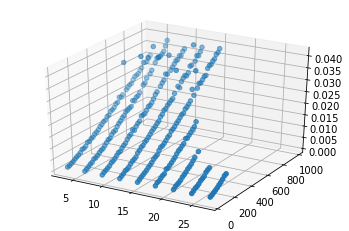

In [32]:


def to_scatterable(X, Y):
  xs = []
  ys = []
  zs = []

  for i in range(min(len(X), len(Y))):
    Xi = X[i]
    Yi = Y[i]

    for j in range(min(len(Xi), len(Yi))):
      (x, y) = Xi[j]
      z = Yi[j]

      xs.append(x)
      ys.append(y)
      zs.append(z)
  return (xs, ys, zs)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
(xs, ys, zs) = to_scatterable(nms, lp_times)
ax.scatter(xs, ys, zs)
plt.show()

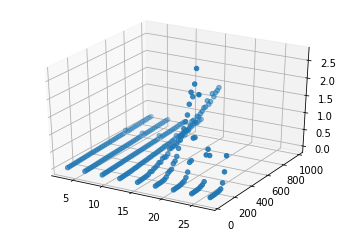

In [34]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
(xs, ys, zs) = to_scatterable(nms, ilp_times)
ax.scatter(xs, ys, zs)
plt.show()

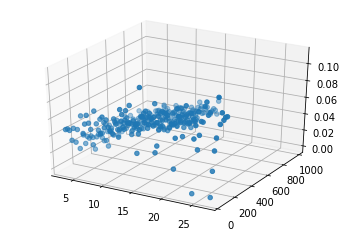

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
(xs, ys, zs) = to_scatterable(nms, errors)
ax.scatter(xs, ys, zs)
plt.show()

In [ ]:
from functools import partial

nms = [[(n * 5, m) for n in range(1, min(20, m // 4))] for m in range(500, 2500, 100)]

ilp_times = []
lp_times = []
errors = []
k = 3
sample_size = 5
time_factor = 2
for arr in nms:
    it = []
    lt = []
    er = []
    for (n, m) in arr:
        tot_error = 0
        tot_ilp_t = 0
        tot_lp_t = 0
        done = False
        count = 0
        # run multiple trials
        for s in range(sample_size):
            ex = F(k, n, m)
            do_lp_algo(ex, k, n, m)
            (resLP, timeLP) = timeFctn(partial(do_lp_algo, ex, k, n, m))
            (bestLP, _, _) = resLP # TODO: take into account the two different rounders

            (resILP, timeILP) = timeFctn(partial(do_ilp_algo, ex, k, n, m, time_lim=timeLP * time_factor, allow_feasible=True))
            # if timed out then stop here
            if resILP is None:
                # done = True
                break
            tot_error += 1 - (bestLP / resILP)
            tot_ilp_t += timeILP
            tot_lp_t += timeLP
            count += 1
        if done is True:
            break
        it.append(tot_ilp_t / count)
        lt.append(tot_lp_t / count)
        er.append(tot_error / count)
        print(f'Finished {n}, {m}')
    ilp_times.append(it)
    lp_times.append(lt)
    errors.append(er)


Finished 5, 500
Finished 10, 500
Finished 15, 500
Finished 20, 500
Finished 25, 500
Finished 30, 500
Finished 35, 500
Finished 40, 500
Finished 45, 500
Finished 50, 500
Finished 55, 500
Finished 60, 500
Finished 65, 500
Finished 70, 500
Finished 75, 500
Finished 80, 500
Finished 85, 500
Finished 90, 500
Finished 95, 500
Finished 5, 600
Finished 10, 600
Finished 15, 600
Finished 20, 600
Finished 25, 600
Finished 30, 600
Finished 35, 600
Finished 40, 600
Finished 45, 600
Finished 50, 600
Finished 55, 600
Finished 60, 600
Finished 65, 600
Finished 70, 600
Finished 75, 600
Finished 80, 600
Finished 85, 600
Finished 90, 600
Finished 95, 600
Finished 5, 700
Finished 10, 700
Finished 15, 700
Finished 20, 700
Finished 25, 700
Finished 30, 700
Finished 35, 700
Finished 40, 700
Finished 45, 700
Finished 50, 700
Finished 55, 700
Finished 60, 700
Finished 65, 700
Finished 70, 700
Finished 75, 700
Finished 80, 700
Finished 85, 700
Finished 90, 700
Finished 95, 700
Finished 5, 800
Finished 10, 800
F

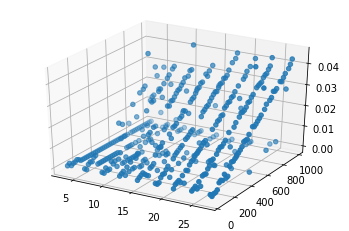

In [55]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
(xs, ys, zs) = to_scatterable(nms, lp_times)
ax.scatter(xs, ys, zs)
plt.show()

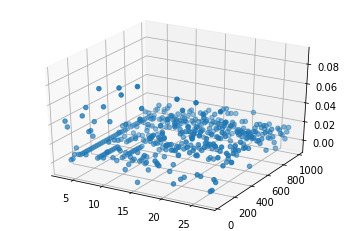

In [56]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
(xs, ys, zs) = to_scatterable(nms, errors)
ax.scatter(xs, ys, zs)
plt.show()

In [48]:
import numpy as np
# stats
var2 = np.var(errors)
mean2 = np.mean(errors)

In [49]:
var2

0.0002814471874906164

In [50]:
mean2

0.03148790147898389